# Model prototypes
**Author:** Scott Campit

The objective of this code is to get around the involved process of labeling images for ConvNet training. The overarching goal for this project is to train a deep neural network to accurately and robustly identify anatomical structures during surgery. 

A secondary (and more ambitious) goal is to predict whether or not there are structures where the surgeon is cutting, getting at temporal and spatial problem as well.

# Import libraries

In [227]:
# Base libraries
import numpy as np
import json
import itertools
import random
import os
import random

# Deep learning libraries
import keras
from keras import layers
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Computer vision libraries
import cv2
import PIL.Image as Image
from skimage import io
import supervisely_lib as sly

# Data visualization libraries
from pylab import rcParams
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# 1. Read in data
We labeled the data using Supervisely. Let's load up the project.

In [206]:
proj_path = "D:/Data/InterOp/Sling Health"
project = sly.Project(proj_path, sly.OpenMode.READ)

If we are going to use ImageNet, the size of the image needs to be 224 x 224.

In [203]:
IMAGE_SHAPE = (224, 224)

Let's load up an image.

In [218]:
item_paths = project.datasets.get("Thyroidectomy").get_item_paths("thyroidectomy_0_9.jpg")
ann = sly.Annotation.load_json_file(item_paths.ann_path, project.meta)

# Read the underlying raw image for display.
img = sly.image.read(item_paths.img_path)
img = cv2.resize(img, dsize=IMAGE_SHAPE)
img = np.array(img) / 255.0

# Render the labeled objects.
ann_render = np.zeros(ann.img_size + (3,), dtype=np.uint8)
ann.draw(ann_render)
ann_render = cv2.resize(ann_render, dsize=IMAGE_SHAPE)

# Separately, render the labeled objects contours.
ann_contours = np.zeros(ann.img_size + (3,), dtype=np.uint8)
ann.draw_contour(ann_contours, thickness=7)
ann_contours = cv2.resize(ann_contours, dsize=IMAGE_SHAPE)

Let's now plot the image.

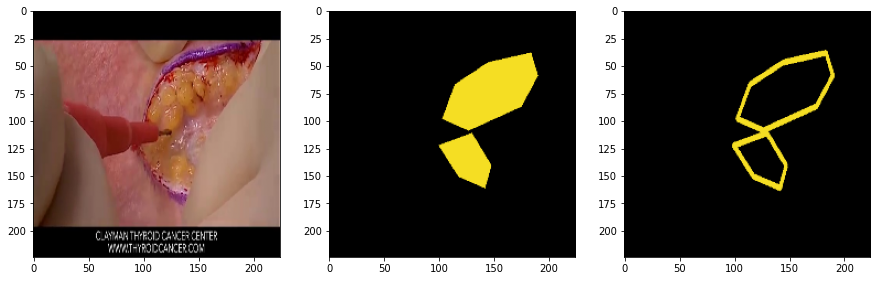

In [219]:
# Plot the image
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(ann_render)
plt.subplot(1, 3, 3)
plt.imshow(ann_contours)

Now let's write up more functions for preprocessing

In [ ]:
def normalize(image, mask):
    """
    """
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    return image, mask

In [ ]:
@tf.function
def load_training_image(datapoint, image_size=(128, 128)):
    """
    """
    image = tf.image.resize(datapoint['image'], image_size)
    mask  = tf.image.resize(datapoint['segmentation_mask'], image_size)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    image, mask = normalize(image, mask)

    return image, mask

In [ ]:
def load_image_test(datapoint, image_size=(128, 128)):
    """
    """
    image = tf.image.resize(datapoint['image'], image_size)
    mask = tf.image.resize(datapoint['segmentation_mask'], image_size)

    image, mask = normalize(image, mask)

    return image, mask

Need to figure out how

In [ ]:
TRAIN_LENGTH = Xtrain.shape[0]
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# 2. Load the model
In this case, we'll load the ImageNet model.

In [217]:
# Number of unique classes from the classification task
OUTPUT_CHANNELS = unique(meta["tags"])

We'll use the MobileNet model for image segmentation.

In [ ]:
# Remove the top layer of the model -> we need to fine tune that.
mdl = tf.keras.applications.MobileNetV2(
    input_shape=[128, 128, 3],
    include_top=False
)

Now let's modify the activation layers and extract it.

In [ ]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [mdl.get_layer(name).output for name in layer_names]

We'll extract the minimum feature extractor. MobileNetV2 is a U-Net model. This goes from large to small.

In [ ]:
# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

Now let's go from small to large.

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Now let's create the U-Net model.

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# 3. Train the model
Now let's train the model

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Let's see what the models predict before training

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                    create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

Now let's create a callback that let's us see how the model does while training.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Finally, let's fit the model.

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Okay, let's evaluate the model

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

And now let's visualize the cost curve.

In [ ]:
epochs = range(EPOCHS)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Make predictions 

In [ ]:
show_predictions(test_dataset, 3)

Add a batch dimension and pass the image to the model.

In [220]:
result = classifier.predict(img[np.newaxis, ...])

## Now let's set up some functions that will facilitate loading the image.

### `LoadImage` scales the data by dividing by 255

### `LoadAnnotation` loads the boundary regions

In [154]:
def LoadAnnotation(filename):
    """
    """
    with open(filename, 'r') as datafile:
        data = json.load(datafile)
    
    # Get the coordinates
    try:
        left = data["objects"][0]["points"]["exterior"][0][0]
        top = data["objects"][0]["points"]["exterior"][0][1]
        right = data["objects"][0]["points"]["exterior"][1][0]
        bottom = data["objects"][0]["points"]["exterior"][1][1]
    except IndexError:
        left, top, right, bottom = 0, 0, 0, 0

    return [left, top, right, bottom]

### `ReadDirFiles` reads the image files from the `img` directory and returns the path of the image and the annotation.

In [50]:
def ReadDirFiles(dirname):
    """
    """
    paths = []
    for file in os.listdir(os.path.join(dirname, "img")):
        basename = os.path.basename(file).split(".")[0]
        
        img_name = os.path.join(dirname, "img", file)
        ann_name = os.path.join(dirname, "ann", basename + ".json")
        paths.append((img_name, ann_name))
    return paths

### `ReadPaths` reads the path names and adds the paths to a list.

In [53]:
def ReadPaths(paths):
    """
    """
    all_paths = []
    for path in paths:
        temp_paths = ReadDirFiles(path)
        all_paths.extend(temp_paths)
    return all_paths

### `get_tags` gets the tags associated with each data file.

In [71]:
def get_tags(filename):
    """
    """
    with open(filename) as datafile:
        data = json.load(datafile)
    tags = data["tags"]
    return tags

### `train_test_split` splits the paths for training and test sets.

In [126]:
def train_test_split(paths, train_size=0.8, train_tag="train", test_tag="test"):
    """
    """
    train_paths = []
    test_paths  = []

    n_img   = len(all_paths)
    train_size = 0.8
    n_train = [train_tag] * round(n_img * train_size)
    n_test  = [test_tag] * (n_img-len(n_train))
    select_tag = n_train + n_test
    random.shuffle(select_tag)

    for i, path in enumerate(paths):
        img_path, ann_path = path
        tags = select_tag[i]
        if train_tag in tags:
            train_paths.append(path)
        if test_tag in tags:
            test_paths.append(path)
    return train_paths, test_paths

Let's first read the paths in the directory.

In [73]:
datapath = ['D:\\Data\\InterOp\\Sling Health\\Thyroidectomy\\']
all_paths = ReadPaths(datapath)
#print(all_paths)

Now let's test the `train_test_split` function.

In [127]:
train_paths, test_paths = train_test_split(all_paths)
print(len(train_paths))
print(len(test_paths))

364
91


Let's create a function that loads the data and the associated tag with it.

In [189]:
def LoadData(paths):
    """
    """
    xs = []
    ys = []
    for ex_paths in paths:
        img_path = ex_paths[0]
        ann_path = ex_paths[1]
        xs.append(LoadImage(img_path))
        ys.append(LoadAnnotation(ann_path))
    
    return xs, ys

This creates the X and Y training and test sets

In [190]:
Xtrain, Ytrain = LoadData(train_paths)
Xtest,  Ytest  = LoadData(test_paths)

# Batch Iterator

In [ ]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed

# Create Tensorflow Neural Network
This bit of code will use the TensorFlow API to tra

## Evaluation metric
First let's create the mean-squared error metric

In [ ]:
def mse(expected, predicted):
    """
    """
    se = tf.square(expected - predicted)
    return tf.reduce_mean(se)

## Train model for transfer learning
Now we'll try to implement a transfer learning scheme for our object segmentation task.

In [202]:
classifier.predict(Xtrain)

WARN:tensorflow:Model was constructed with shape (None, 224, 224, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input'), name='keras_layer_input', description="created by layer 'keras_layer_input'"), but it was called on an input with incompatible shape (None, 640, 3).
WARN:tensorflow:Model was constructed with shape (None, 224, 224, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input'), name='keras_layer_input', description="created by layer 'keras_layer_input'"), but it was called on an input with incompatible shape (None, 640, 3).


ValueError: in user code:

    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow_hub\keras_layer.py:235 call  *
        result = smart_cond.smart_cond(training,
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\saved_model\load.py:668 _call_attribute  **
        return instance.__call__(*args, **kwargs)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\eager\def_function.py:828 __call__
        result = self._call(*args, **kwds)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\eager\def_function.py:862 _call
        results = self._stateful_fn(*args, **kwds)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\eager\function.py:2941 __call__
        filtered_flat_args) = self._maybe_define_function(args, kwargs)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\eager\function.py:3361 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\eager\function.py:3196 _create_graph_function
        func_graph_module.func_graph_from_py_func(
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\framework\func_graph.py:990 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\eager\def_function.py:634 wrapped_fn
        out = weak_wrapped_fn().__wrapped__(*args, **kwds)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\saved_model\function_deserialization.py:267 restored_function_body
        raise ValueError(

    ValueError: Could not find matching function to call loaded from the SavedModel. Got:
      Positional arguments (4 total):
        * Tensor("inputs:0", shape=(None, 640, 3), dtype=float32)
        * False
        * False
        * 0.99
      Keyword arguments: {}
    
    Expected these arguments to match one of the following 4 option(s):
    
    Option 1:
      Positional arguments (4 total):
        * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
        * True
        * True
        * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
      Keyword arguments: {}
    
    Option 2:
      Positional arguments (4 total):
        * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
        * True
        * False
        * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
      Keyword arguments: {}
    
    Option 3:
      Positional arguments (4 total):
        * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
        * False
        * False
        * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
      Keyword arguments: {}
    
    Option 4:
      Positional arguments (4 total):
        * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
        * False
        * True
        * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
      Keyword arguments: {}


# 2. Run YOLO out of the box
Let's see how YOLO performs. First load the api


In [15]:
settings = {
    "gpu_device": 1,
}
team = api.team
#applier = model_applier(settings)
#prediction = applier.inference(img, ann)

In [16]:
print(team.id)

AttributeError: 'TeamApi' object has no attribute 'id'

# Set an autoencoder
Now we'll create a simple autoencoder. This will probably fail, but we'll try to upgrade ASAP.

In [42]:
# The fully connected autoencoder.
encoding_dim = 32
input_img = keras.Input(shape=(200, ))
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(200, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded)

# Let's also create a separate encoder/decoder model
encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim, ))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# View a snapshot of the images
Let's now pull some random images from our data folder.

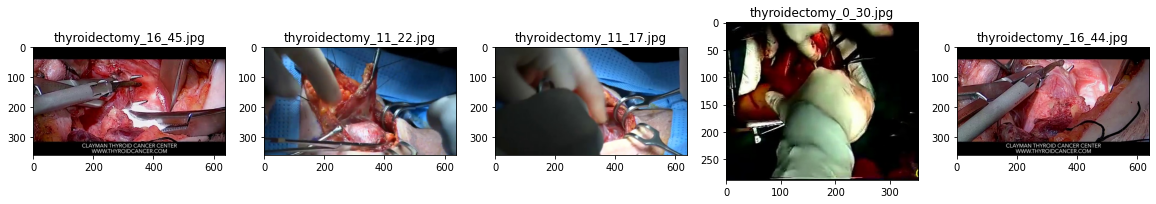

In [11]:
folder_path = r'D:/Data/InterOp/Thyroidectomy'
plt.figure(figsize=(20,20))

for i in range(5):
    file = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, file)
    img = mpimg.imread(image_path)
    ax = plt.subplot(1, 5, i+1)
    ax.title.set_text(file)
    plt.imshow(img)

# Standardize the image dataset
Now we need to perform some image preprocessing, including:

  1. Resize the image to the correct dimension
  2. Convert the image file to a color format
  3. Convert the image to a numpy array with float32 data type
  4. Normalize the image array to have values scaled between 0 and 1 from 0 to 255.


In [29]:
def create_imgdb(img_path, train_size=0.8):
    """
    """
    all_filenames = os.listdir(img_path)
    random.shuffle(all_filenames)
    train_idx = int(train_size*len(all_filenames))
    train_filenames = all_filenames[:train_idx]
    test_filenames = all_filenames[train_idx:]

    def create_np_dataset(img_path, filenames):
        """
        """
        data = []
        for file in filenames:
            tmp = os.path.join(img_path, file)
            img = cv2.imread(tmp, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_height, img_width), interpolation=cv2.INTER_AREA)
            img = np.array(img).astype('float32')
            img /= 255
            data.append(img)
            return(data)

    train_data = create_np_dataset(img_path, train_filenames)
    test_data = create_np_dataset(img_path, test_filenames)
    return(train_data, test_data)

We'll set the dimensions to be 200x200 pixels and create our dataset

In [38]:
img_height=200
img_width=200
train_data, test_data = create_imgdb(folder_path, train_size=0.8)

Let's show one image of the preprocessed data

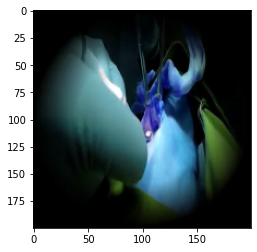

In [39]:
plt.imshow(train_data[0])

# Train the autoencoder
Now let's train the autoencoder

In [40]:
train_data = np.array(train_data, np.float32)
test_data = np.array(test_data, np.float32)
print(train_data)

[[[[0.00392157 0.00392157 0.00392157]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.00392157 0.00392157 0.00392157]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

In [43]:
autoencoder.fit(train_data, train_data,
                epochs=50,
                batch_size=256, 
                shuffle=True,
                validation_data=(test_data, test_data))

Epoch 1/50


ValueError: in user code:

    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Scott\Envs\Python\pycv\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_2 is incompatible with the layer: expected axis -1 of input shape to have value 200 but received input with shape (None, 200, 200, 3)
